# Model interpretation for Visual Question Answering


In this notebook we demonstrate how to apply model interpretability algorithms from captum library on VQA models. More specifically we explain model predictions by applying integrated gradients on a small sample of image-question pairs. More details about Integrated gradients can be found in the original paper: https://arxiv.org/pdf/1703.01365.pdf

As a reference VQA model we use the following open source implementation:
https://github.com/Cyanogenoid/pytorch-vqa

In [9]:
import os, sys
import numpy as np

# Clone PyTorch VQA project from: https://github.com/Cyanogenoid/pytorch-vqa and add to your filepath
# Replace <PROJECT-DIR> placeholder with your project directory path
sys.path.append(os.path.realpath('<PROJECT-DIR>/pytorch-vqa'))

# Clone PyTorch Resnet model from: https://github.com/Cyanogenoid/pytorch-resnet and add to your filepath
# We can also use standard resnet model from torchvision package, however the model from `pytorch-resnet` 
# is slightly different from the original resnet model and performs better on this particular VQA task
sys.path.append(os.path.realpath('<PROJECT-DIR>/pytorch-resnet'))

In [10]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

import resnet  # from pytorch-resnet

import matplotlib.pyplot as plt
from PIL import Image

from model import Net, apply_attention, tile_2d_over_nd # from pytorch-vqa
from utils import get_transform # from pytorch-vqa

from captum.attr import IntegratedGradients
from captum.attr import InterpretableEmbeddingBase, TokenReferenceBase
from captum.attr import visualization, configure_interpretable_embedding_layer, remove_interpretable_embedding_layer


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Loading VQA model

VQA model can be downloaded from: 
https://github.com/Cyanogenoid/pytorch-vqa/releases/download/v1.0/2017-08-04_00.55.19.pth

In [12]:
saved_state = torch.load('models/2017-08-04_00.55.19.pth', map_location=device)

# reading vocabulary from saved model
vocab = saved_state['vocab']

# reading word tokens from saved model
token_to_index = vocab['question']

# reading answers from saved model
answer_to_index = vocab['answer']

num_tokens = len(token_to_index) + 1

# reading answer classes from the vocabulary
answer_words = ['unk'] * len(answer_to_index)
for w, idx in answer_to_index.items():
    answer_words[idx]=w


In [13]:
# Load the predefined model
# `device_ids` contains a list of GPU ids which are used for paralelization supported by `DataParallel`
vqa_net = torch.nn.DataParallel(Net(num_tokens), device_ids=[0,1])
vqa_net.load_state_dict(saved_state['weights'])
vqa_net.to(device)
vqa_net.eval()


DataParallel(
  (module): Net(
    (text): TextProcessor(
      (embedding): Embedding(15193, 300, padding_idx=0)
      (drop): Dropout(p=0.5, inplace=False)
      (tanh): Tanh()
      (lstm): LSTM(300, 1024)
    )
    (attention): Attention(
      (v_conv): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (q_lin): Linear(in_features=1024, out_features=512, bias=True)
      (x_conv): Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
      (drop): Dropout(p=0.5, inplace=False)
      (relu): ReLU(inplace=True)
    )
    (classifier): Classifier(
      (drop1): Dropout(p=0.5, inplace=False)
      (lin1): Linear(in_features=5120, out_features=1024, bias=True)
      (relu): ReLU()
      (drop2): Dropout(p=0.5, inplace=False)
      (lin2): Linear(in_features=1024, out_features=3000, bias=True)
    )
  )
)

Converting string question into a tensor. `encode_question` function is similar to original implementation of `encode_question` method in pytorch-vqa source code.
https://github.com/Cyanogenoid/pytorch-vqa/blob/master/data.py#L110



In [6]:
def encode_question(question):
    """ Turn a question into a vector of indices and a question length """
    question_arr = question.lower().split()
    vec = torch.zeros(len(question_arr), device=device).long()
    for i, token in enumerate(question_arr):
        index = token_to_index.get(token, 0)
        vec[i] = index
    return vec, torch.tensor(len(question_arr), device=device)


# Defining end-to-end VQA model

Original saved model does not have image network's (resnet's) layers attached to it. We attach it in the below cell using forward-hook. The rest of the model is identical to the original definition of the model: https://github.com/Cyanogenoid/pytorch-vqa/blob/master/model.py#L48

In [7]:
class ResNetLayer4(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.r_model = resnet.resnet152(pretrained=True)
        self.r_model.eval()
        self.r_model.to(device)
        self.buffer = None

        def save_output(module, input, output):
            self.buffer = output

        self.r_model.layer4.register_forward_hook(save_output)

    def forward(self, x):
        self.r_model(x)
        return self.buffer

class VQA_Resnet_Model(Net):
    def __init__(self, embedding_tokens):
        super().__init__(embedding_tokens)
        self.resnet_layer4 = ResNetLayer4()
    
    def forward(self, v, q, q_len):
        q = self.text(q, list(q_len.data))
        v = self.resnet_layer4(v)

        v = v / (v.norm(p=2, dim=1, keepdim=True).expand_as(v) + 1e-8)

        a = self.attention(v, q)
        v = apply_attention(v, a)

        combined = torch.cat([v, q], dim=1)
        answer = self.classifier(combined)
        return answer


Updating weights from the saved model and removing the old model from the memory.

In [8]:
vqa_resnet = VQA_Resnet_Model(vqa_net.module.text.embedding.num_embeddings)
# `device_ids` contains a list of GPU ids which are used for paralelization supported by `DataParallel`
vqa_resnet = torch.nn.DataParallel(vqa_resnet, device_ids=[0,1])

# saved vqa model's parameters
partial_dict = vqa_net.state_dict()

state = vqa_resnet.state_dict()
state.update(partial_dict)
vqa_resnet.load_state_dict(state)

vqa_resnet.to(device)
vqa_resnet.eval()

# This is original VQA model without resnet. Removing it, since we do not need it
del vqa_net


In [24]:
image_size = 448  # scale image to given size and center
central_fraction = 1.0

transform = get_transform(image_size, central_fraction=central_fraction)
    
def image_to_features(img):
    img_transformed = transform(img)
    img_batch = img_transformed.unsqueeze(0).to(device)
    return img_batch


In order to explain text features, we introduce interpretable embedding layers which allows access word embeddings and generate meaningful attributions for each embedding dimension.

configure_interpretable_embedding_layer function separates embedding layer from the model and precomputes word embeddings in advance. The embedding layer of our model is then being replaced by an Interpretable Embedding Layer which wraps original embedding layer and takes word embedding vactors as inputs of the forward function. This allows to generate baselines for word embeddings and compute attributions for each embedding dimension.

Note: After finishing interpretation it is important to call remove_interpretable_embedding_layer which removes the Interpretable Embedding Layer that we added for interpretation purposes and sets the original embedding layer back in the model.

In [28]:
interpretable_embedding = configure_interpretable_embedding_layer(vqa_resnet, 'module.text.embedding')

Creating reference aka baseline / background for questions. This is specifically necessary for baseline-based model interpretability algorithms. In this case for integrated gradients. More details can be found in the original paper: https://arxiv.org/pdf/1703.01365.pdf

In [11]:
PAD_IND = token_to_index['pad']
token_reference = TokenReferenceBase(reference_token_idx=PAD_IND)

In [12]:
# this is necessary for the backpropagation of RNNs models in eval mode
torch.backends.cudnn.enabled=False


Creating an instance of integrated gradients. It will be used to intepret model's predictions.

In [13]:
ig = IntegratedGradients(vqa_resnet)

Defining a few test images for model intepretation purposes

In [14]:
images = ['./img/vqa/siamese.jpg',
          './img/vqa/elephant.jpg',
          './img/vqa/zebra.jpg']

In [15]:
def vqa_resnet_interpret(image_filename, questions, targets):
    img = Image.open(image_filename).convert('RGB')
    original_image = transforms.Compose([transforms.Scale(int(image_size / central_fraction)),
                                   transforms.CenterCrop(image_size), transforms.ToTensor()])(img) 
    
    image_features = image_to_features(img).requires_grad_().to(device)
    for question, target in zip(questions, targets):
        q, q_len = encode_question(question)

        q_input_embedding = interpretable_embedding.indices_to_embeddings(q).unsqueeze(0)

        # Making prediction. The output of prediction will be visualized later
        ans = vqa_resnet(image_features, q_input_embedding, q_len.unsqueeze(0))
        pred, answer_idx = F.softmax(ans, dim=1).data.cpu().max(dim=1)
        
        # generate reference for each sample
        q_reference_indices = token_reference.generate_reference(q_len.item(), 
                                                                 device=device).unsqueeze(0)
        q_reference = interpretable_embedding.indices_to_embeddings(q_reference_indices).to(device)
        attributions, delta = ig.attribute(inputs=(image_features, q_input_embedding),
                                            baselines=(image_features * 0.0, q_reference),
                                            target=answer_idx,
                                            additional_forward_args=q_len.unsqueeze(0),
                                            n_steps=30)
        # Visualize text attributions
        text_attributions_norm = attributions[1].sum(dim=2).squeeze(0).norm()
        vis_data_records = [visualization.VisualizationDataRecord(
                                attributions[1].sum(dim=2).squeeze(0) / text_attributions_norm,
                                pred[0].item(),
                                answer_words[ answer_idx ],
                                answer_words[ answer_idx ],
                                target,
                                attributions[1].sum(),       
                                question.split(),
                                0.0)]
        visualization.visualize_text(vis_data_records)

        # visualize image attributions
        transformed_img = transform(img).cpu().detach().numpy()
        img_integrated_gradient_overlay = visualization.visualize_image(
                                        np.transpose(attributions[0].squeeze(0).cpu().detach().numpy(),
                                                     (1, 2, 0)),
                                        np.transpose(transformed_img , (1, 2, 0)),
                                        clip_above_percentile=99,
                                        clip_below_percentile=0,
                                        overlay=True, mask_mode=True)

        # concatenating original image with the corresponding overlayed 
        image_grid = torchvision.utils.make_grid(torch.stack([original_image,
                                                           torch.Tensor(img_integrated_gradient_overlay).permute(2,0,1)]),
                                                 nrow=2, padding=4)
        plt.figure(figsize = (50, 5))
        plt.imshow((image_grid.permute(1,2,0).detach().numpy()* 255).astype(np.uint8), alpha=0.9)
        plt.show()
        print('Text Contributions: ', attributions[1].sum().item())
        print('Image Contributions: ', attributions[0].sum().item())
        print('Total Contribution: ', attributions[0].sum().item() + attributions[1].sum().item())


In [ ]:
# the index of image in the test set. Please, change it if you want to play with different test images/samples.
image_idx = 1 # elephant
vqa_resnet_interpret(images[image_idx], [
    "what is on the picture",
    "what color is the elephant",
    "where is the elephant"
], ['elephant', 'gray', 'zoo'])

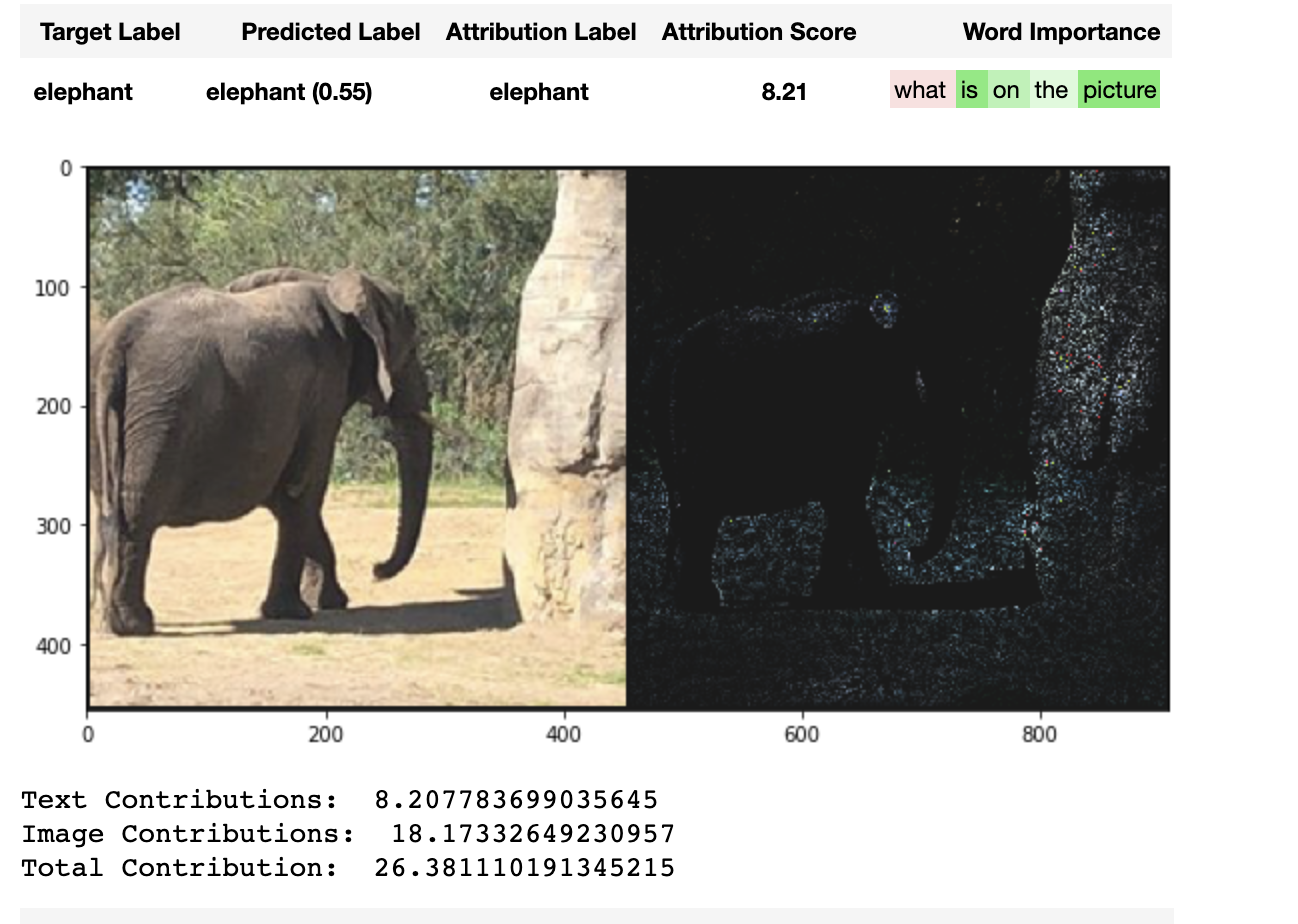

In [16]:
import IPython
# Above cell generates an output similar to this:
IPython.display.Image(filename='img/vqa/elephant_attribution.jpg')

In [ ]:
image_idx = 0 # cat

vqa_resnet_interpret(images[image_idx], [
    "what is on the picture",
    "what color are the cat's eyes",
    "is the animal in the picture a cat or a fox",
    "what color is the cat",
    "how many ears does the cat have",
    "where is the cat"
], ['cat', 'blue', 'cat', 'white and brown', '2', 'at the wall'])

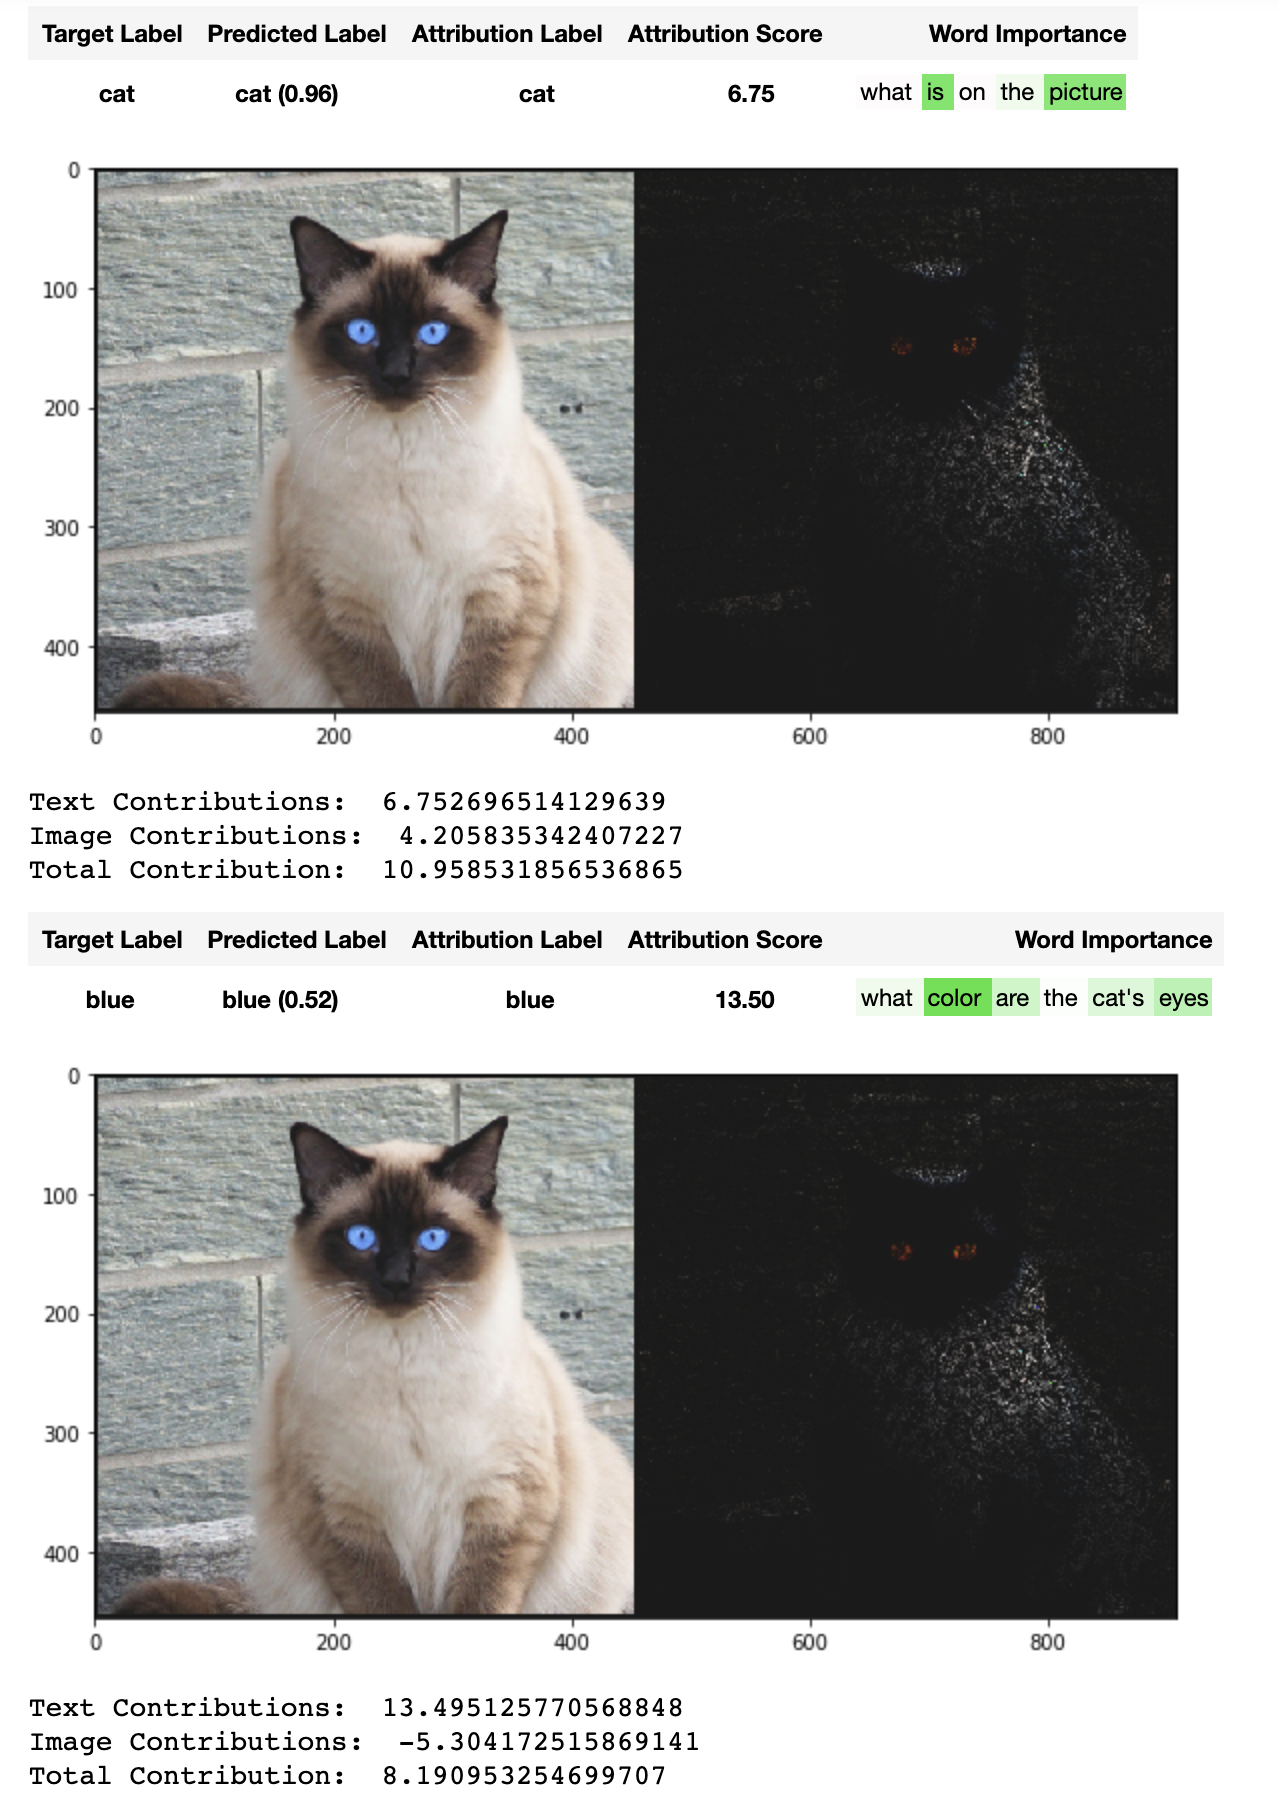

In [17]:
# Above cell generates an output similar to this:
IPython.display.Image(filename='img/vqa/siamese_attribution.jpg')

In [ ]:
image_idx = 2 # zebra

vqa_resnet_interpret(images[image_idx], [
    "what is on the picture",
    "what color are the zebras",
    "how many zebras are on the picture",
    "where are the zebras"
], ['zebra', 'black and white', '2', 'zoo'])


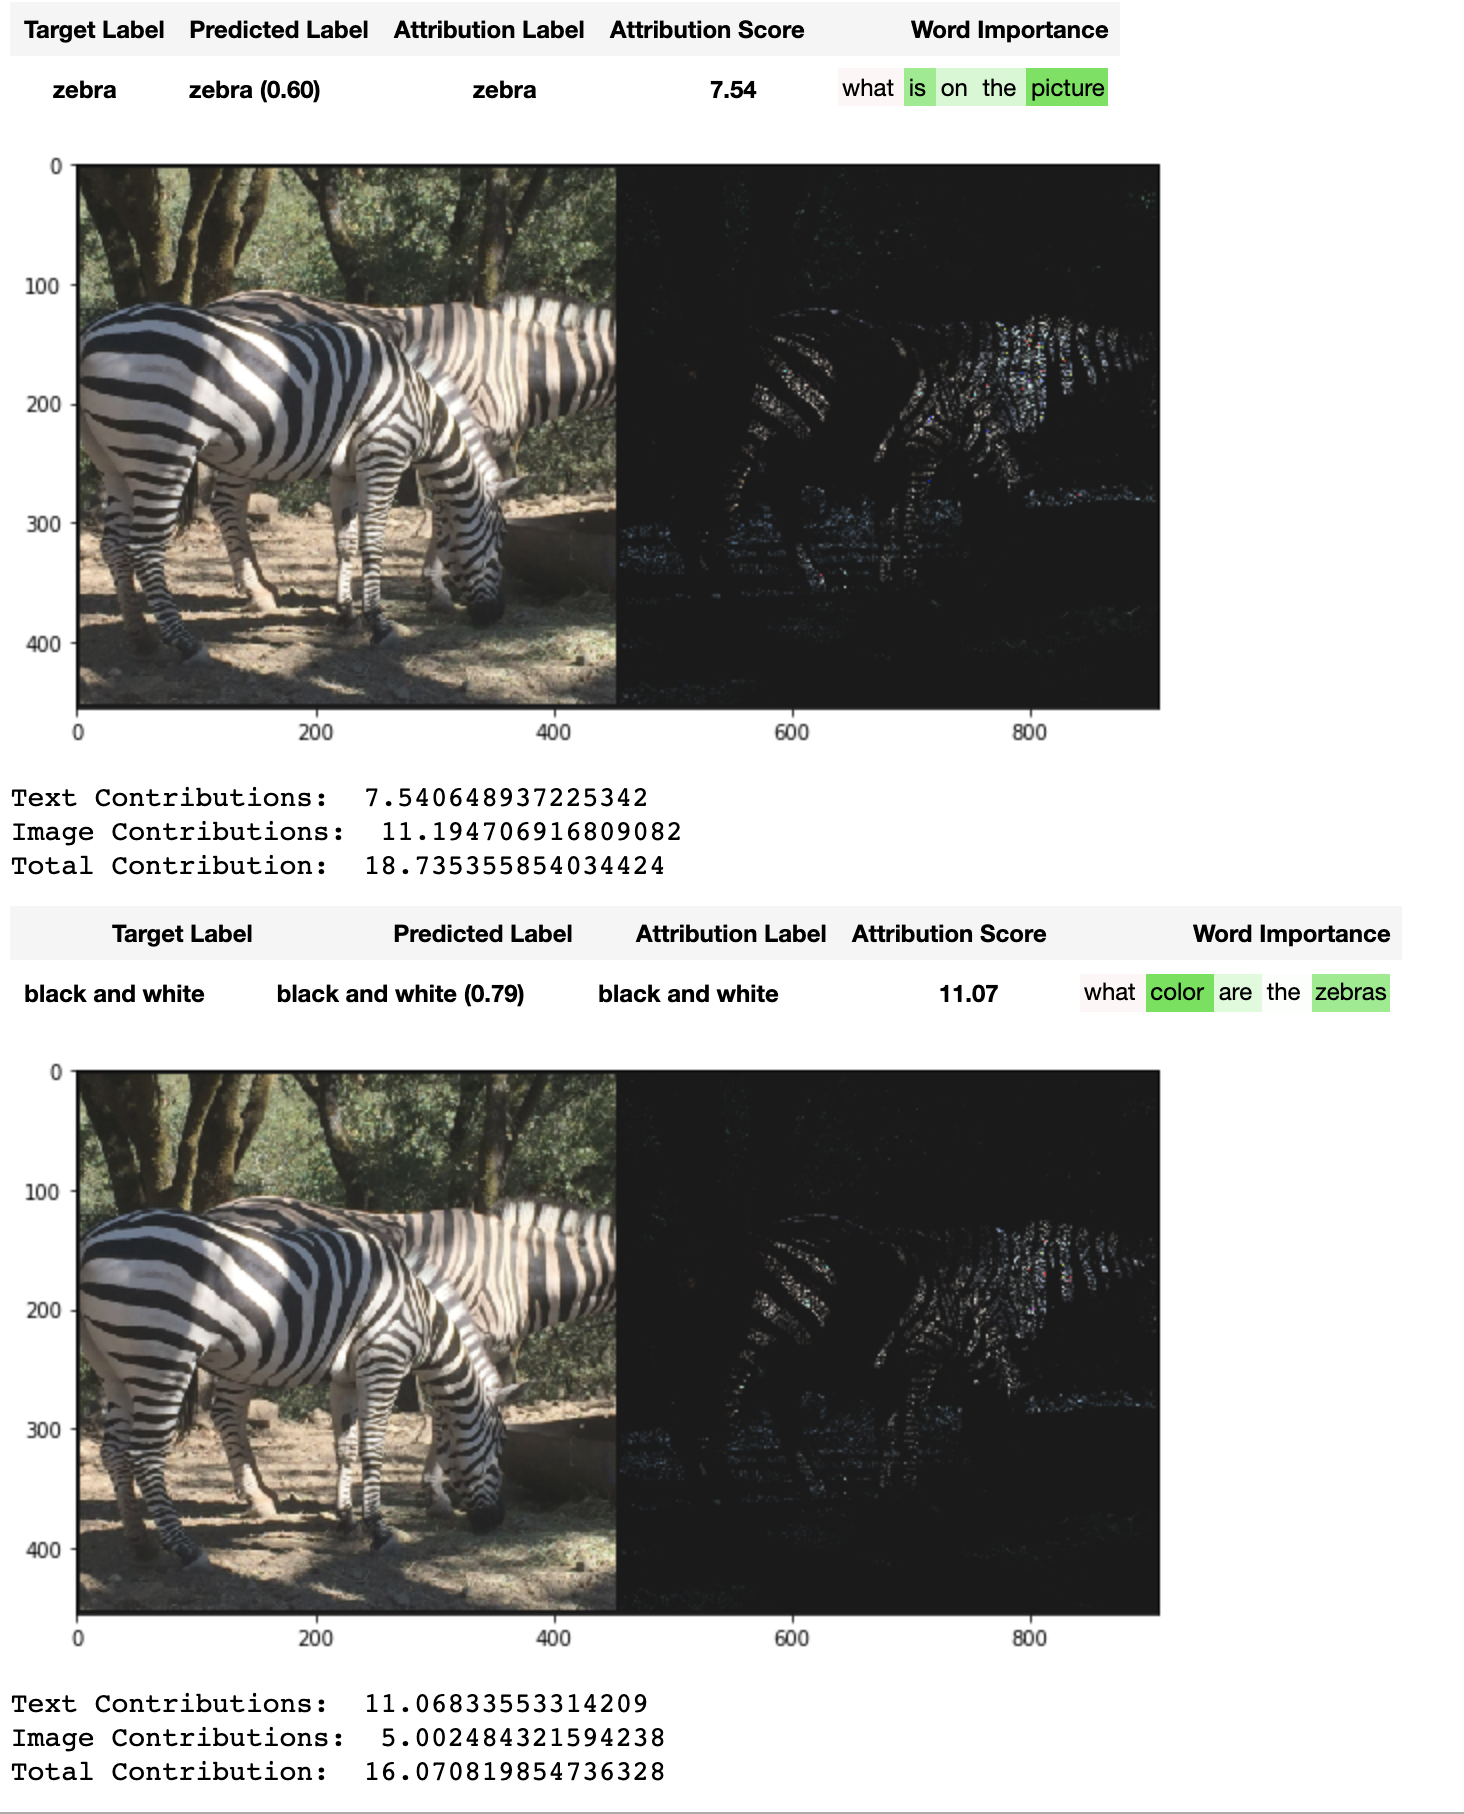

In [18]:
# Above cell generates an output similar to this:
IPython.display.Image(filename='img/vqa/zebra_attribution.jpg')

As mentioned above, after we are done with interpretation, we have to remove Interpretable Embedding Layer and set the original embeddings layer back to the model.

In [27]:
remove_interpretable_embedding_layer(vqa_resnet, interpretable_embedding)